In [1]:
import sys, os
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
root_dir = '/mnt/home/spandey/ceph/CHARM/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from charm.utils_data_prep_cosmo_vel_conc_peak import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
import matplotlib
import matplotlib.pyplot as pl

abs_path_config = os.path.abspath(root_dir + "run_configs/") 
abs_path_data = os.path.abspath(root_dir + "data/") 
abs_path_checkpoint = os.path.abspath(root_dir + "model_checkpoints/") 
%load_ext autoreload
%autoreload 2




In [2]:
run_config_name = 'TRAIN_CONC_FREECOSMO_cond_fastpm_ns128_200c.yaml'
with open(abs_path_config + '/' + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']

ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
# K_M1 = config_net['K_M1']
# B_M1 = config_net['B_M1']
# nflows_M1_NSF = config_net['nflows_M1_NSF']

K_conc = config_net['K_conc']
B_conc = config_net['B_conc']
nflows_conc_NSF = config_net['nflows_conc_NSF']

# base_dist_Ntot = config_net['base_dist_Ntot']
# if base_dist_Ntot == 'None':
#     base_dist_Ntot = None
# base_dist_M1 = config_net['base_dist_M1']
base_dist_conc = config_net['base_dist_conc']

cond_Mass_for_conc = config_net['cond_Mass_for_conc']

# ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params



In [3]:
import pickle as pk
# df = pk.load(open('/mnt/home/spandey/ceph/CHARM/data/HALO_MASS_VEL_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_QUIJOTE.pk', 'rb'))
# df = pk.load(open(abs_path_data + '/' + 'HALO_MASS_test14656_QUIJOTE_test.pk', 'rb'))
df = pk.load(open(abs_path_data + '/' + 'HALO_MASS_rockstar_200c_VEL_NU_CONC_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_QUIJOTE.pk', 'rb'))    

df_d_all_train = df['df_d_all_train']
df_d_all_nsh_train = df['df_d_all_nsh_train']
df_Mh_all_train = df['df_Mh_all_train'].todense()
df_Nh_train = df['df_Nh_train'].todense()
# df_vh_train = df['df_vh_train'].todense()
# df_nuh_train = df['df_nuh_train'].todense()
df_ch_train = df['df_ch_train'].todense()
ind_subsel_all_train = df['ind_subsel_all_train']
ind_subsel_fid_train = df['ind_subsel_fid_train']
cosmo_val_all_train = df['cosmo_val_all_train']





In [5]:
df_Nh_train.shape




(29312, 16, 16, 16)

In [7]:
# 192*128
29312/128


229.0

In [ ]:
# nsims_per_batch, nbatches_train = 250, 4
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=None, df_c_inp=df_ch_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True
    )




In [4]:
import pickle as pk
df = pk.load(open(abs_path_data + '/' + 'DENSITY_varycosmo_subsel_random_nsims1800_nspji16_nfid512_train_data_FASTPM.pk', 'rb'))
# df = pk.load(open(abs_path_data + '/' + 'DENSITY_test14656_FASTPM_test.pk', 'rb'))
# df = pk.load(open(abs_path_data + '/' + 'DENSITY_test11000_FASTPM_test.pk', 'rb'))
df_d_all_train_FP = df['df_d_all_train']
df_d_all_nsh_train_FP = df['df_d_all_nsh_train']
df_Mh_all_train_FP = df['df_Mh_all_train']
df_Nh_train_FP = df['df_Nh_train']
try:
    df_vh_train_FP = df['df_vh_train']
except:
    df_vh_train_FP = None
    pass
ind_subsel_all_train_FP = df['ind_subsel_all_train']
ind_subsel_fid_train_FP = df['ind_subsel_fid_train']
cosmo_val_all_train_FP = df['cosmo_val_all_train']


# # Prepare the density and halo data
return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, df_v_inp=df_vh_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
    )

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
    cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

    cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])




In [5]:
cond_tensor.shape



torch.Size([64, 96, 4, 24, 24, 24])

In [6]:
# import pickle as pk
# import numpy as np

# df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, df_vh_train, df_ch_train, ind_subsel_all_train, ind_subsel_fid_train, cosmo_val_all_train = load_density_halo_data_NGP(
#     ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
#     sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
#     sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
#     LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
#     stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria, is_HR = is_HR,  vel_type='diff',conc_type='diff',
#     get_density=False, 
#     get_halos=True
#     )



In [7]:
# df_Mh_all_train.shape, df_Nh_train.shape, df_vh_train.shape, df_ch_train.shape, ind_subsel_fid_train.shape, cosmo_val_all_train.shape
# df_d_all_train.shape, df_d_all_nsh_train.shape, 



In [8]:
# df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, df_vh_train_FP, df_ch_train_FP, ind_subsel_all_train_FP, ind_subsel_fid_train_FP, cosmo_val_all_train_FP = load_density_halo_data_NGP(
#     ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
#     sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH',
#     sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',  
#     LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
#     stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria,
#     indsubsel_all_inp=ind_subsel_all_train,
#     indsubsel_fid_inp=ind_subsel_fid_train,
#     is_HR = is_HR,  vel_type='diff',
#     get_density=True,
#     get_halos=False
#     )
# if cosmo_val_all_train_FP is None:
#     cosmo_val_all_train_FP = cosmo_val_all_train




In [9]:
df_d_all_train_FP.shape, df_d_all_nsh_train_FP.shape



((29312, 4, 24, 24, 24), (29312, 4, 16, 16, 16))

In [10]:
# saved = {'df_d_all_train':df_d_all_train_FP,
#             'df_d_all_nsh_train':df_d_all_nsh_train_FP,
#             'df_Mh_all_train':df_Mh_all_train_FP,
#             'df_Nh_train':df_Nh_train_FP,
#             'df_vh_train_FP':df_vh_train_FP,
#             'ind_subsel_all_train':ind_subsel_all_train_FP,
#             'ind_subsel_fid_train':ind_subsel_fid_train_FP,
#             'cosmo_val_all_train':cosmo_val_all_train_FP
#             }

# import pickle as pk
# nsims = int(config_sims['nsims'])
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/' + f'DENSITY_varycosmo_subsel_random_nsims{nsims}_nspji{nsubvol_per_ji}_nfid{nsubvol_fid}' + '_train_data_FASTPM.pk', 'wb'))


In [11]:
# import sparse
# saved = {'df_d_all_train':df_d_all_train,
#             'df_d_all_nsh_train':df_d_all_nsh_train,
#             'df_Mh_all_train':sparse.COO(df_Mh_all_train),
#             'df_Nh_train':sparse.COO(df_Nh_train),
#             'df_vh_train':sparse.COO(df_vh_train),
#             'ind_subsel_all_train':ind_subsel_all_train,
#             'ind_subsel_fid_train':ind_subsel_fid_train,
#             'cosmo_val_all_train':cosmo_val_all_train
#             }

# import pickle as pk
# nsims = int(config_sims['nsims'])
# pk.dump(saved, open('/mnt/home/spandey/ceph/CHARM/data/' + f'HALO_MASS_{mass_type}_VEL_varycosmo_subsel_random_nsims{nsims}_nspji{nsubvol_per_ji}_nfid{nsubvol_fid}' + '_train_data_QUIJOTE.pk', 'wb'))



In [12]:
import sys, os
import torch
import torch.distributed as dist
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import time
os.environ['TORCH_DISTRIBUTED_DEBUG'] = 'DETAIL'
os.environ['NCCL_BLOCKING_WAIT'] = '0'
from datetime import timedelta
import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch.optim as optim
import pickle as pk
from charm.combined_models import *
from charm.all_models import *
from charm.utils_data_prep_cosmo_vel_conc_peak import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
# get directory of this file, absolute path:
import pathlib
curr_path = pathlib.Path().absolute()




In [48]:
num_cond



29

In [13]:
# # nsims_per_batch, nbatches_train = 250, 4
# return_dict_train = prep_density_halo_cats_batched(
#     df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=df_vh_train, df_c_inp=df_ch_train, nsims=nsims_per_batch,
#     nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True
#     )


# # # Prepare the density and halo data
# return_dict_train_FP = prep_density_halo_cats_batched(
#     df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, df_v_inp=df_vh_train_FP, df_c_inp=df_ch_train_FP, nsims=nsims_per_batch,
#     nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
#     )

# if return_dict_train_FP is not None:
#     cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
#     cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
#     cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
#     cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
#     cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
# else:
#     cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
#     cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
#     cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#     cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
#     cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])


ndim_mass = Nmax
ndim_conc = Nmax

c_halos_all = return_dict_train['c_halos_all_sort_norm'].reshape(*return_dict_train['c_halos_all_sort_norm'].shape[:-2],-1)
# v_halos_all = return_dict_train['v_halos_all_sort_norm'].reshape(*return_dict_train['v_halos_all_sort_norm'].shape[:-2],-1)
M_halos_all = return_dict_train['M_halos_all_sort_norm'].reshape(*return_dict_train['M_halos_all_sort_norm'].shape[:-2],-1)

mask_conc = return_dict_train['mask_vel']
# mask_vel_repeat = np.repeat(mask_vel[..., None], 3, axis=-1)
# mask_vel_repeat = mask_vel_repeat.reshape(*mask_vel_repeat.shape[:-2],-1)
# mask_tensor_vel_train = torch.Tensor((mask_vel_repeat)).reshape(-1, nsims_per_batch * (nax_h**3), ndim_vel)
mask_tensor_conc_train = torch.Tensor((mask_conc)).reshape(-1, nsims_per_batch * (nax_h**3), ndim_conc)

X_conc = torch.Tensor(np.array(c_halos_all)).reshape(-1, nsims_per_batch * (nax_h**3),ndim_conc)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
Mhalos_truth_tensor = torch.Tensor(((np.array(M_halos_all)))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_mass)


In [14]:
cond_Mass_for_conc


True

In [15]:
# num_cond_conc = num_cond
if cond_Mass_for_conc:
    num_cond_conc = num_cond + ndim_mass
else:
    num_cond_conc = num_cond
model_conc = NSF_Autoreg_CNNcond(
    dim=ndim_conc,
    K=K_conc,
    B=B_conc,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_conc,
    nflows=nflows_conc_NSF,
    base_dist=base_dist_conc,
    mu_pos=False
    )


# ndim = ndim_diff + 1
model = COMBINED_Model_conc_only(
    None,
    model_conc,
    ndim_conc,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    ).to(dev)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()




In [16]:
# ndim_conc
num_cond_conc


41

In [17]:
X_conc_jb = X_conc.to(dev)
Nhalos_truth_tensor_jb = Nhalos_truth_tensor.to(dev)
Mhalos_truth_tensor_jb = Mhalos_truth_tensor.to(dev)
mask_tensor_conc_train_jb = mask_tensor_conc_train.to(dev)
cond_tensor_jb = cond_tensor.to(dev)
cond_tensor_nsh_jb = cond_tensor_nsh.to(dev)
cond_cosmo_jb = cond_cosmo.to(dev)
mask_tensor_conc_train_jb = mask_tensor_conc_train.to(dev)


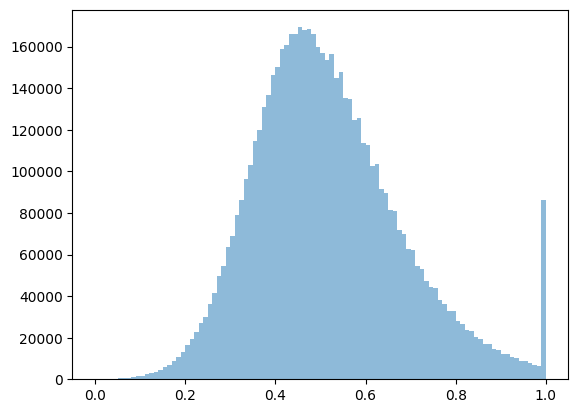

In [18]:
pl.figure()
conc_inp = X_conc_jb.detach().cpu().numpy().flatten()
indsel = np.where(conc_inp != 0.5)[0]
_ = pl.hist(conc_inp[indsel], range=(0,1), bins=100, alpha=0.5, label='sampled')
# conc_out = conc_samp_out.flatten()
# indsel = np.where(conc_out != 0)[0]
# _ = pl.hist(conc_out[indsel], range=(0,1), bins=100, alpha=0.5, label='sampled')
# pl.yscale('log')




In [19]:
decay_lr = True # whether to decay the learning rate
decay_lr_model = 'cosine'
min_lr = 1e-4 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
iter_num = 0
local_iter_num = 0 # number of iterations in the lifetime of this process
# raw_model = model.module
running_mfu = -1.0    
best_val_loss = 1e20
loss_min = 1e20
nbatches = 10
# max_iters = 1800
eval_interval = 20
save_separate_interval = 20

nepochs = 1500
warmup_iters = int(nepochs//15) # how many steps to warm up for
lr_decay_iters = int(nepochs*1.5) # should be ~= max_iters per Chinchilla

# learning rate decay scheduler (cosine with warmup)
def get_lr(it, model='cosine'):
    # 1) linear warmup for warmup_iters steps
    if model == 'cosine':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)
    
    elif model == 'linear':
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        else:
            return learning_rate - (it - warmup_iters) * (learning_rate - min_lr) / (lr_decay_iters - warmup_iters)

    elif model == 'constant':
        return learning_rate

# t0 = time.time()
for iter_num in (range(nepochs)):
    lr = get_lr(iter_num, model=decay_lr_model) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


    loss = model(
        X_conc_jb,
        cond_tensor_jb,
        cond_tensor_nsh_jb,
        cond_cosmo_jb,
        Nhalos_truth_tensor_jb,
        Mhalos_truth_tensor_jb,
        # None,
        mask_tensor_conc_train_jb         
        )            

    # if (rank == 0) and (iter_num == 0):
    #     print('GPU memory usage after calling model forward once:')
    #     for i in range(torch.cuda.device_count()):
    #         print(f"GPU {i}:")
    #         print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
    #         print(f"  Reserved:  {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")

    scaler.scale(loss).backward()   
    if (iter_num % 10) == 0:
        print(f"iter {iter_num}, loss: {loss.item()}")                 


    if (np.mod(iter_num, int(nepochs / 80)) == 0) or (iter_num == nepochs - 1):
        if float(loss.mean().cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.mean().cpu().detach().numpy())
            print(loss_min)

            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                        'loss':loss}

            # save_bestfit_model_name = sdir_model_checkpoint + 'test_model_bestfit_' + str(1000+iter_num) + '_evenmoredata_nsub11k.pth'
            # torch.save(
            #     state, save_bestfit_model_name
            #     )

    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # if (rank == 0) and (iter_num == 0):
    #     print('GPU memory usage after passing gradients backward once:')
    #     for i in range(torch.cuda.device_count()):
    #         print(f"GPU {i}:")
    #         print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
    #         print(f"  Reserved:  {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")



/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


iter 0, loss: 146.6631317138672
146.6631317138672
iter 10, loss: 136.9097900390625
114.79971313476562
iter 20, loss: 107.41851806640625
iter 30, loss: 54.94834899902344


KeyboardInterrupt: 

In [74]:
conc_samp_out = model.inverse(cond_x=cond_tensor_jb, cond_x_nsh=cond_tensor_nsh_jb, cond_cosmo=cond_cosmo_jb, mask_conc_truth=mask_tensor_conc_train_jb, Nhalos_truth=Nhalos_truth_tensor_jb, Mhalos_truth=Mhalos_truth_tensor_jb)




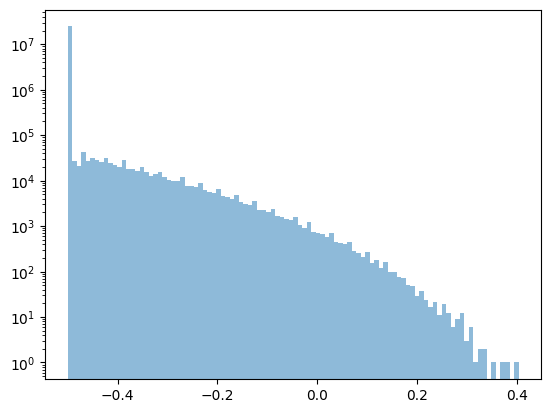

In [75]:
# cond_tensor_nsh_jb.shape
# Mhalos_truth_tensor_jb.shape
pl.figure()
_ = pl.hist(Mhalos_truth_tensor_jb.detach().cpu().numpy().flatten(), bins=100, alpha=0.5, label='truth')
pl.yscale('log')



In [76]:
# conc_samp_out_
cmin = -4
cmax = 4
cout_orig = conc_samp_out * (cmax - cmin) + cmin


In [77]:
conc_samp_out.shape, X_conc_jb.detach().cpu().numpy().shape


((1, 2097152, 12), (1, 2097152, 12))

Text(0.5, 0, '$\\Delta c$ normalized')

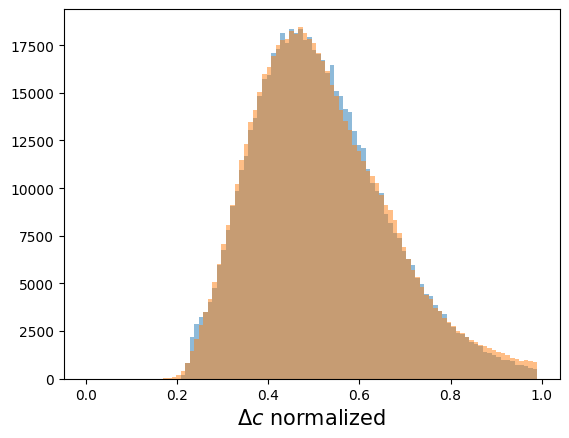

In [78]:
pl.figure()
conc_inp = X_conc_jb.detach().cpu().numpy().flatten()
indsel = np.where(conc_inp != 0.5)[0]
_ = pl.hist(conc_inp[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
conc_out = conc_samp_out.flatten()
indsel = np.where(conc_out != 0)[0]
_ = pl.hist(conc_out[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
# pl.yscale('log')
pl.xlabel(r'$\Delta c$ normalized', fontsize=15)


Text(0.5, 0, '$\\Delta c$ normalized')

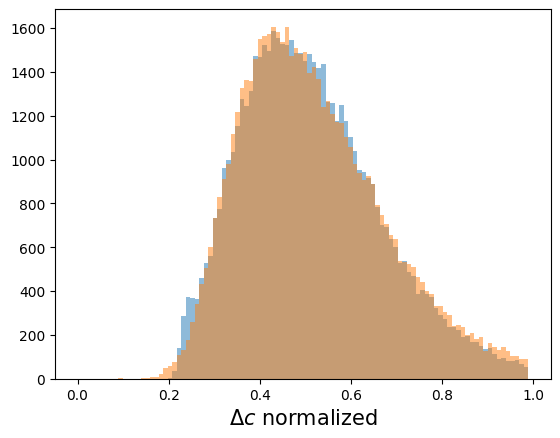

In [97]:
pl.figure()
conc_inp = X_conc_jb.detach().cpu().numpy()[...,2].flatten()
indsel = np.where(conc_inp != 0.5)[0]
_ = pl.hist(conc_inp[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
conc_out = conc_samp_out[...,2].flatten()
indsel = np.where(conc_out != 0)[0]
_ = pl.hist(conc_out[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
# pl.yscale('log')
pl.xlabel(r'$\Delta c$ normalized', fontsize=15)


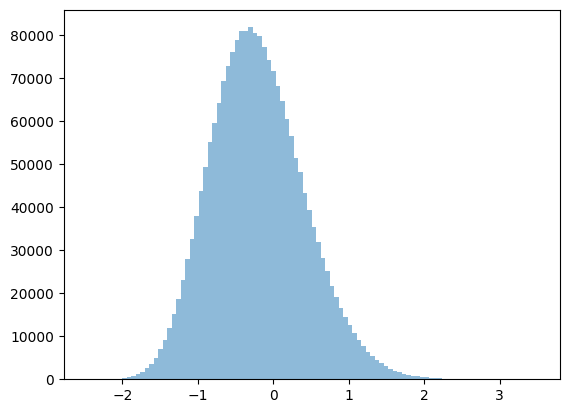

In [70]:
deltaval = cond_tensor_nsh_jb.detach().cpu().numpy()[...,0][0,:]
pl.figure()
_ = pl.hist(deltaval.flatten(), bins=100, alpha=0.5, label='sampled')


Text(0.5, 1.0, 'Third heaviest mass halo')

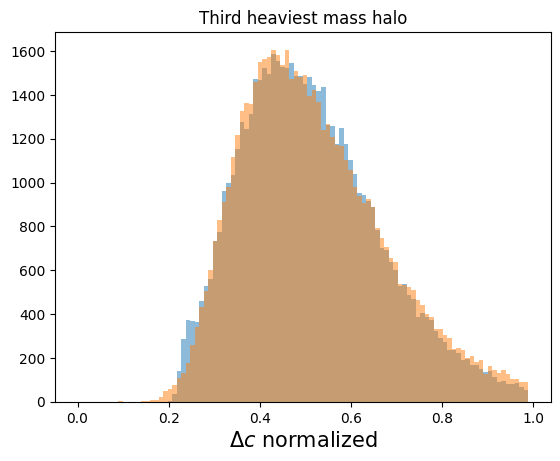

In [114]:
pl.figure()
conc_inp = X_conc_jb.detach().cpu().numpy()[...,2].flatten()
# indsel = np.where((conc_inp != 0.5) & (deltaval < 0.3))[0]
indsel = np.where((conc_inp != 0.5))[0]
_ = pl.hist(conc_inp[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
conc_out = conc_samp_out[...,2].flatten()
# indsel = np.where((conc_out != 0) & (deltaval < 0.3))[0]
indsel = np.where((conc_out != 0))[0]
_ = pl.hist(conc_out[indsel], range=(0,0.99), bins=100, alpha=0.5, label='sampled')
# pl.yscale('log')
pl.xlabel(r'$\Delta c$ normalized', fontsize=15)
pl.title('Third heaviest mass halo')


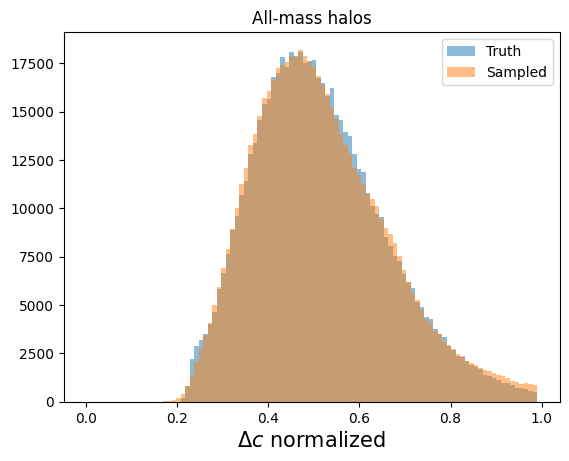

In [83]:
Mall = Mhalos_truth_tensor_jb.detach().cpu().numpy()[0,...]
indsel = np.where((Mall > -0.5) & (Mall < 0.5))
# indsel = np.where((Mall > -0.5) & (Mall < -0.2))
# indsel = np.where((Mall > -0.2) & (Mall < 0.1))
# indsel = np.where((Mall > 0.1) & (Mall < 0.45))
pl.figure()
conc_inp = X_conc_jb.detach().cpu().numpy()[0,...]
# indsel = np.where((conc_inp != 0.5) & (deltaval < 0.3))[0]
# indsel = np.where((conc_inp != 0.5))[0]
_ = pl.hist(conc_inp[indsel], range=(0,0.99), bins=100, alpha=0.5, label='Truth')
conc_out = conc_samp_out[0,...]
# indsel = np.where((conc_out != 0) & (deltaval < 0.3))[0]
# indsel = np.where((conc_out != 0))[0]
_ = pl.hist(conc_out[indsel], range=(0,0.99), bins=100, alpha=0.5, label='Sampled')
# pl.yscale('log')
pl.xlabel(r'$\Delta c$ normalized', fontsize=15)
pl.title('All-mass halos')
pl.legend()
# pl.yscale('log')


In [28]:
Mhalos_truth_tensor_jb.detach().cpu().numpy().shape, X_conc_jb.detach().cpu().numpy().shape, conc_samp_out.shape


((1, 2097152, 12), (1, 2097152, 12), (1, 2097152, 12))

In [32]:
Mall[indsel]


array([[-0.3215332 , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.1262207 , -0.3383789 , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.3996582 , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       ...,
       [-0.35205078, -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.31298828, -0.38012695, -0.41918945, ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.31298828, -0.38012695, -0.41918945, ..., -0.5       ,
        -0.5       , -0.5       ]], dtype=float32)